In [1]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from sklearn.utils import resample

In [2]:
import pandas as pd
df = pd.read_csv('Emotion_final.csv')


In [3]:
df

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
21454,Melissa stared at her friend in dism,fear
21455,Successive state elections have seen the gover...,fear
21456,Vincent was irritated but not dismay,fear
21457,Kendall-Hume turned back to face the dismayed ...,fear


In [4]:
df.head()


,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


<Axes: xlabel='Emotion', ylabel='count'>

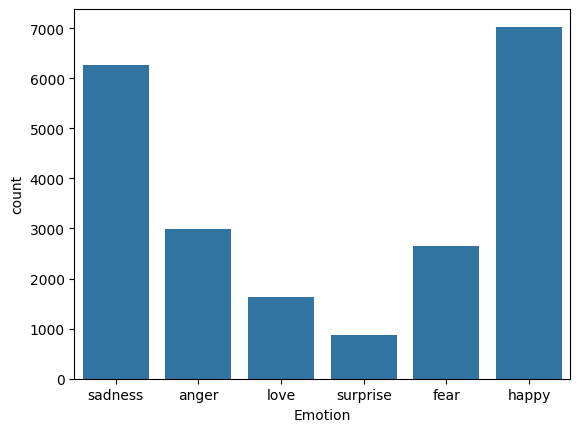

In [5]:
sns.countplot(x = "Emotion", data = df)


In [6]:
# upsample surprise
n_surp_sample = 1000
surp = df[df["Emotion"] == "surprise"]
surp_upsample = resample(surp, random_state = 35, n_samples=n_surp_sample, replace = True)

# upsample love
n_love_sample = 500
love = df[df["Emotion"] == "love"]
love_upsample = resample(love, random_state = 35, n_samples=n_love_sample, replace = True)

df = pd.concat([df, surp_upsample, love_upsample])

<Axes: xlabel='Emotion', ylabel='count'>

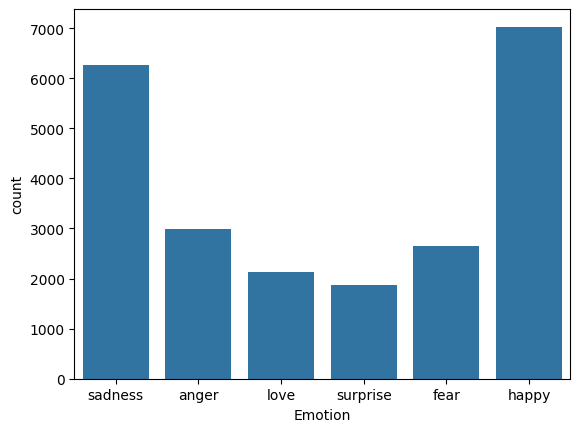

In [7]:
sns.countplot(x = "Emotion", data = df)


<Axes: >

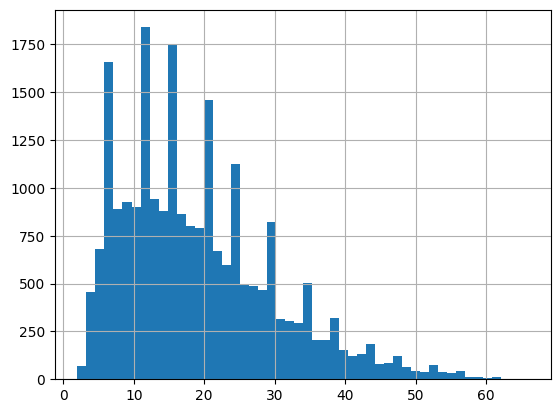

In [8]:
seq_len = (len(i.split()) for i in df['Text'])
pd.Series(seq_len).hist(bins = 50)

In [9]:
encoder = OneHotEncoder()
X = np.array(df.Text)
y = encoder.fit_transform(np.array(df.Emotion).reshape(-1,1)).toarray()

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train)

In [11]:
tokenize_data = Tokenizer(oov_token='<UNK>', split=" ")
tokenize_data.fit_on_texts(X)

In [12]:
tokenize_train = tokenize_data.texts_to_sequences(X_train)
vec_train = pad_sequences(tokenize_train, padding="post", maxlen=50)

tokenize_val = tokenize_data.texts_to_sequences(X_val)
vec_val = pad_sequences(tokenize_val, padding="post", maxlen=50)

tokenize_test = tokenize_data.texts_to_sequences(X_test)
vec_test = pad_sequences(tokenize_test, padding="post", maxlen=50)

vocab_size = len(tokenize_data.word_index) + 1

In [13]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, Dropout, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [14]:
from tensorflow.keras import Input

model = Sequential()
model.add(Input(shape=(50,)))  # <-- Explicit input shape
model.add(Embedding(input_dim=vocab_size, output_dim=128))
model.add(Bidirectional(LSTM(units=256, dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(units=256, dropout=0.2, return_sequences=True)))
model.add(GlobalAveragePooling1D())
model.add(Dense(units=512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(units=128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(units=6, activation='softmax'))


In [15]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "/content/model.keras",  # Correct Path for Colab
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='auto'
)


In [16]:
# opt = Adam(learning_rate=0.001)
# model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# # Now fit
# t = time.time()
# his = model.fit(x=vec_train, y=y_train, batch_size=128, epochs=10,
#                 validation_data=(vec_val, y_val), callbacks=[checkpoint])
# print(f'Time taken: {time.time() - t}')


from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Add callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True)

# Now fit
t = time.time()
his = model.fit(
    x=vec_train,
    y=y_train,
    batch_size=128,
    epochs=20,  # Give it room to train, early stopping will kick in
    validation_data=(vec_val, y_val),
    callbacks=[checkpoint, early_stop, reduce_lr]
)
print(f'Time taken: {time.time() - t}')


Epoch 1/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.2268 - loss: 1.9655

146/146 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.2273 - loss: 1.9641 - val_accuracy: 0.3512 - val_loss: 1.6294 - learning_rate: 0.0010
Epoch 2/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.5940 - loss: 1.0874 - val_accuracy: 0.3169 - val_loss: 1.8860 - learning_rate: 0.0010
Epoch 3/20
145/146 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8909 - loss: 0.3281

146/146 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.8910 - loss: 0.3278 - val_accuracy: 0.6294 - val_loss: 0.9129 - learning_rate: 0.0010
Epoch 4/20
145/146 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9582 - loss: 0.1332

146/146 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.9581 - loss: 0.1333 - val_accuracy: 0.7441 - val_loss: 0.8888 - learning_rate: 0.0010
Epoch 5/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.9702 - loss: 0.0913 - val_accuracy: 0.7678 - val_loss: 0.9308 - learning_rate: 0.0010
Epoch 6/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9790 - loss: 0.0636

146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.9790 - loss: 0.0636 - val_accuracy: 0.8824 - val_loss: 0.4003 - learning_rate: 0.0010
Epoch 7/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9800 - loss: 0.0613

146/146 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.9800 - loss: 0.0613 - val_accuracy: 0.8979 - val_loss: 0.3786 - learning_rate: 0.0010
Epoch 8/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.9859 - loss: 0.0429 - val_accuracy: 0.8360 - val_loss: 0.7090 - learning_rate: 0.0010
Epoch 9/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9862 - loss: 0.0395
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
146/146 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.9862 - loss: 0.0395 - val_accuracy: 0.8447 - val_loss: 0.6567 - learning_rate: 0.0010
Epoch 10/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.9913 - loss: 0.0303 - val_accuracy: 0.8902 - val_loss: 0.4456 - learning_rate: 5.0000e-04
Time taken: 102.41481590270996


In [17]:
import os
print("Saved models:", [f for f in os.listdir('/content/') if f.endswith('.keras')])


Saved models: []


In [18]:
# evaluation
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
class_names = ["anger", "fear", "happy", "love", "sadness", "surprise"]

def model_Evaluate(model, X_test, y_test):

    t = time.time()
    y_pred = model.predict(X_test)
    t = time.time() - t
    y_pred = y_pred.argmax(axis=-1)
    y_test = y_test.argmax(axis=-1)

    print(f'Prediction time: {t/len(y_pred)}')
    print(classification_report(y_test, y_pred))

    for title, normalize in titles_options:
      disp = ConfusionMatrixDisplay.from_predictions(
          y_test,
          y_pred,
          display_labels=class_names,
          cmap=plt.cm.Blues,
          normalize=normalize,
      )
      disp.ax_.set_title(title)
      plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
      plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)

In [20]:
model = tf.keras.models.load_model("/content/best_model.h5")


72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
Prediction time: 0.0011345744132995605
              precision    recall  f1-score   support

           0       0.87      0.81      0.84       299
           1       0.91      0.76      0.83       265
           2       0.89      0.93      0.91       703
           3       0.88      0.78      0.83       214
           4       0.88      0.96      0.92       627
           5       0.90      0.92      0.91       188

    accuracy                           0.89      2296
   macro avg       0.89      0.86      0.87      2296
weighted avg       0.89      0.89      0.89      2296



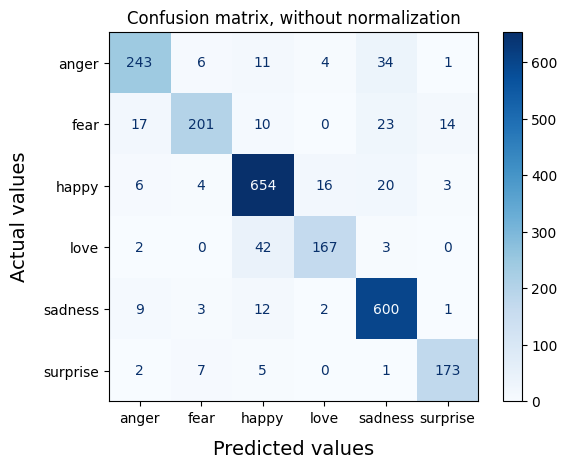

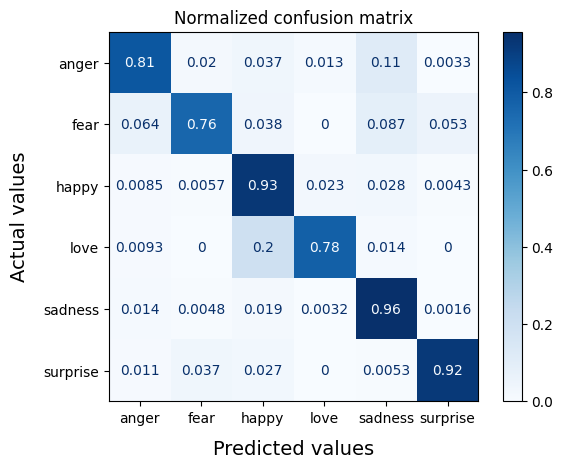

In [21]:
model_Evaluate(model=model, X_test=vec_test, y_test=y_test)


In [22]:
# Emotion labels in the same order as one-hot encoded vectors
emotion_labels = encoder.categories_[0].tolist()

# Take 5 random samples from the dataset
sample_texts = df.sample(5, random_state=42)['Text'].tolist()

# Preprocess (tokenize + pad) the same way as training
sample_sequences = tokenize_data.texts_to_sequences(sample_texts)
sample_padded = pad_sequences(sample_sequences, padding="post", maxlen=50)

# Predict
predictions = model.predict(sample_padded)

# Display results
for i, text in enumerate(sample_texts):
    pred_class = emotion_labels[np.argmax(predictions[i])]
    print(f"\nText: {text}\nPredicted Emotion: {pred_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step

Text: i feel like i had this bitchy undertone the whole convo like kinda sarcastic
Predicted Emotion: anger

Text: im far ahead than the released tankouban that are sold here it just wont be the same anymore and the wait wont be as thrilling but damn me if i even feel slightly remorseful for that
Predicted Emotion: sadness

Text: i love but these are just a few that i ve been thinking of lately feel free to comment tell me i am an idiot or whatever
Predicted Emotion: happy

Text: i see anything that would cause me to feel fearful or distrustful of him
Predicted Emotion: fear

Text: i feel so excited for college
Predicted Emotion: happy


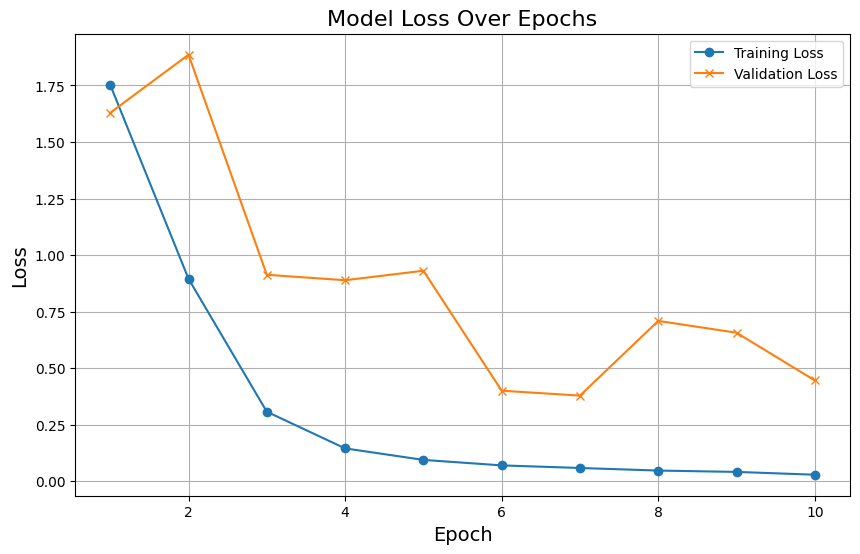

In [23]:
import matplotlib.pyplot as plt

# Extract training history
train_loss = his.history['loss']
val_loss = his.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='x')
plt.title('Model Loss Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()
